# Annotated Code for Loading and Processing scRNA-seq Data with Scanpy

## Importing Libraries

In [1]:
import sys
import pandas

# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval (if needed)
import pooch

### Set ScanPy Settings

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

## Load the scRNA-seq data from a CSV file

In [3]:
samples = {
    "scRNA": "jack-data/bcc_scRNA_counts.txt",
}
adatas = {}

for sample_id, filename in samples.items():
    path = filename
    sample_adata = sc.read_csv(path, delimiter='\t', first_column_names=True).transpose()
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 53030 × 23309
    obs: 'sample'

### Preview Data

In [4]:
df = adata.to_df()
df.head()

FO538757.2  AP006222.2  RP11-206L10.9  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA         0.0         0.0            0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG         0.0         0.0            0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC         0.0         0.0            0.0   
bcc.su001.pre.tcell_AAACGGGTCATACGGT         0.0         0.0            0.0   
bcc.su001.pre.tcell_AAACGGGTCATAGCAC         0.0         0.0            0.0   

                                      LINC00115  FAM41C  NOC2L  KLHL17  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA        1.0     0.0    0.0     0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG        0.0     0.0    0.0     0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC        0.0     0.0    0.0     0.0   
bcc.su001.pre.tcell_AAACGGGTCATACGGT        0.0     0.0    0.0     0.0   
bcc.su001.pre.tcell_AAACGGGTCATAGCAC        0.0     0.0    0.0     0.0   

                                      PLEKHN1  HES4  ISG15  ...  THRIL  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA      0.0   0.0    2.0  ...    0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG      0.0   0.0    0.0  ...    0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC      0.0   0.0    0.0  ...    0.0   
bcc.su001.pre.tcell_AAACGGGTCATACGGT      0.0   0.0    0.0  ...    0.0   
bcc.su001.pre.tcell_AAACGGGTCATAGCAC      0.0   0.0    0.0  ...    0.0   

                                      IGHV3-29  RP11-715J22.4  CTA-363E6.7  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA       0.0            0.0          0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG       0.0            0.0          0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC       0.0            0.0          0.0   
bcc.su001.pre.tcell_AAACGGGTCATACGGT       0.0            0.0          0.0   
bcc.su001.pre.tcell_AAACGGGTCATAGCAC       0.0            0.0          0.0   

                                      RP11-538I12.2  RP11-314A20.5  FNDC8  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA            0.0            0.0    0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG            0.0            0.0    0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC            0.0            0.0    0.0   
bcc.su001.pre.tcell_AAACGGGTCATACGGT            0.0            0.0    0.0   
bcc.su001.pre.tcell_AAACGGGTCATAGCAC            0.0            0.0    0.0   

                                      CTC-360G5.6  XXbac-B135H6.18  GGTLC2  
bcc.su001.pre.tcell_AAACCTGCAGATCGGA          0.0              0.0     0.0  
bcc.su001.pre.tcell_AAACCTGCAGGGATTG          0.0              0.0     0.0  
bcc.su001.pre.tcell_AAACGGGCATAGACTC          0.0              0.0     0.0  
bcc.su001.pre.tcell_AAACGGGTCATACGGT          0.0              0.0     0.0  
bcc.su001.pre.tcell_AAACGGGTCATAGCAC          0.0              0.0     0.0  

[5 rows x 23309 columns]

## Quality Control

### Annotate mitochondrial, ribosomal, and hemoglobin genes

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

#### Visualize the quality metrics

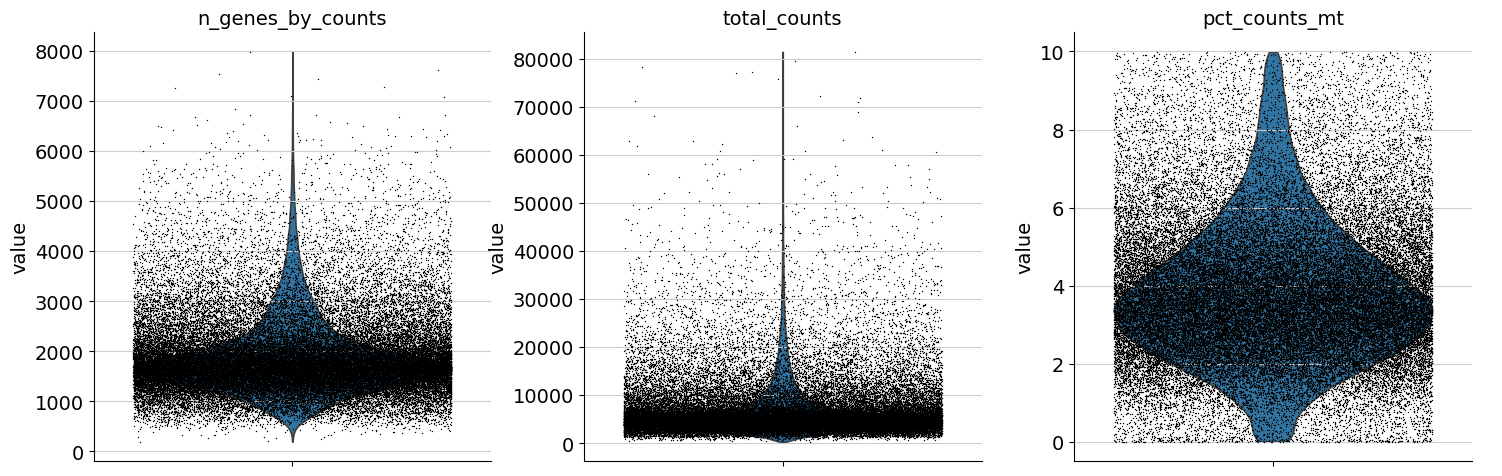

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

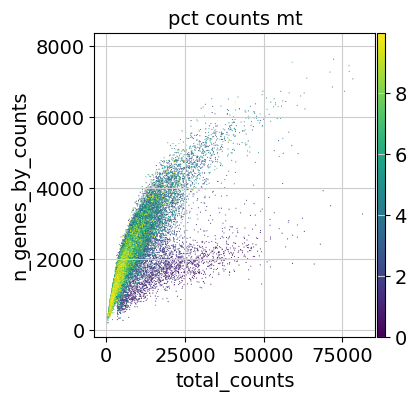

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

## Doublet Detection

In [10]:
sc.pp.scrublet(adata, batch_key="sample")

## Normalization

In [11]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [12]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature Detection

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

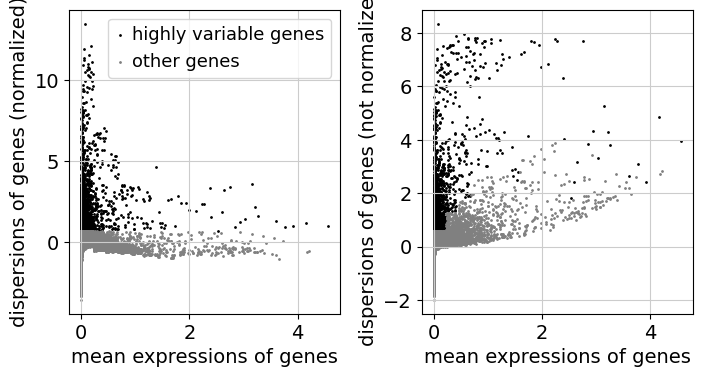

In [14]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [15]:
sc.tl.pca(adata)

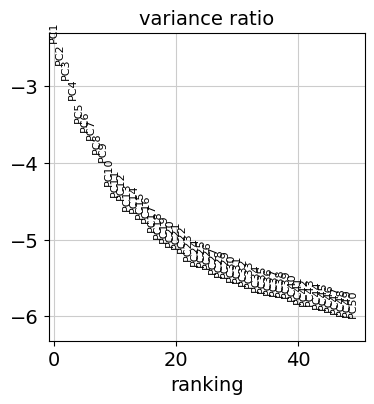

In [16]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

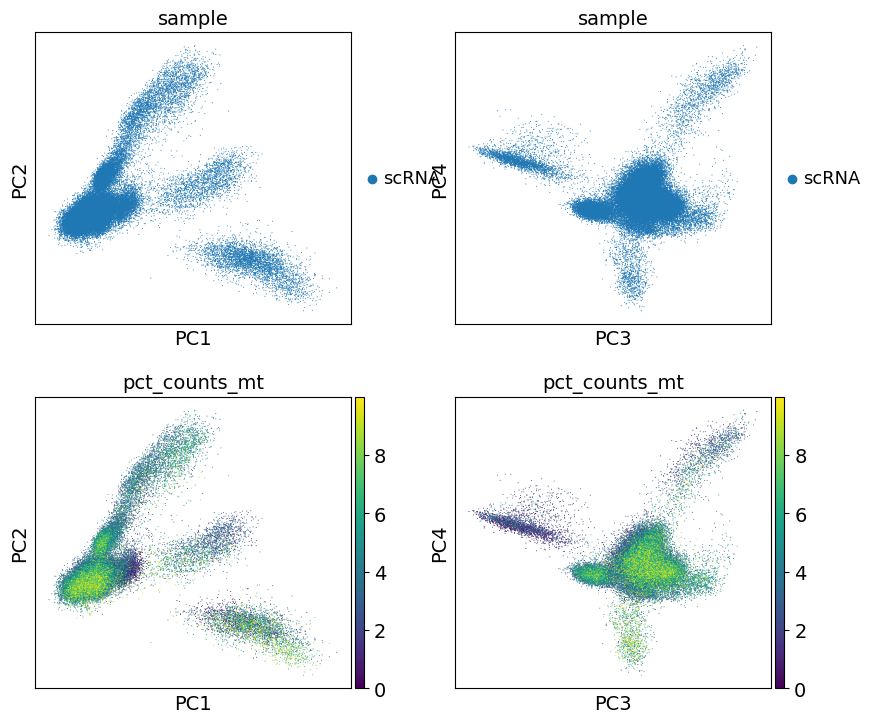

In [17]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Nearest Neighbor Graph Construction and Visualization

In [18]:
sc.pp.neighbors(adata)

2024-08-07 17:08:33.731057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 17:08:34.685344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
sc.tl.umap(adata)

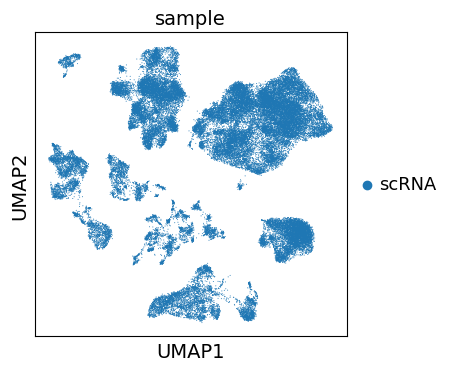

In [20]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

## Clustering

In [21]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

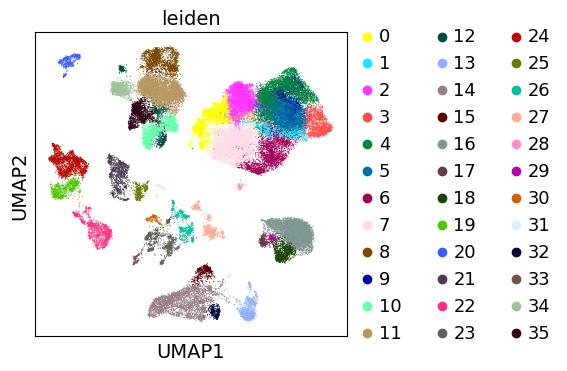

In [22]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess Quality Control and Cell Filtering

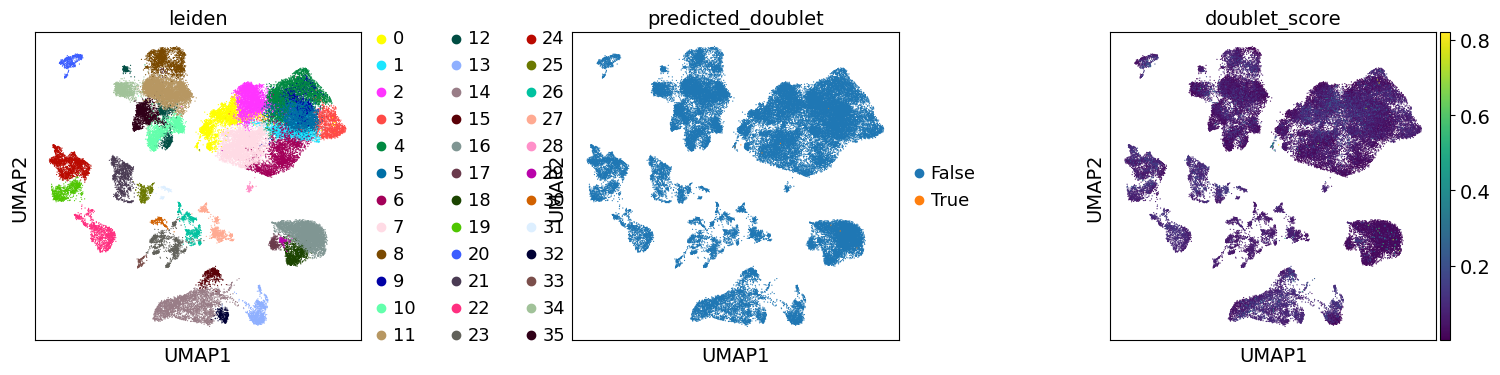

In [23]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

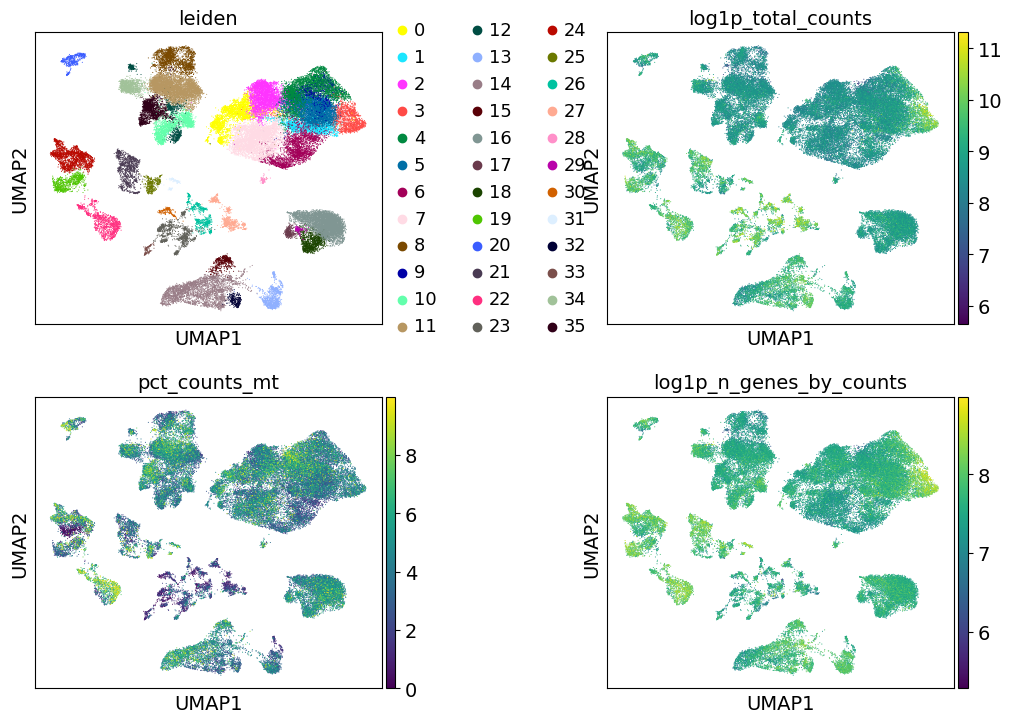

In [24]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

## Manual Cell-type Annotation

In [25]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

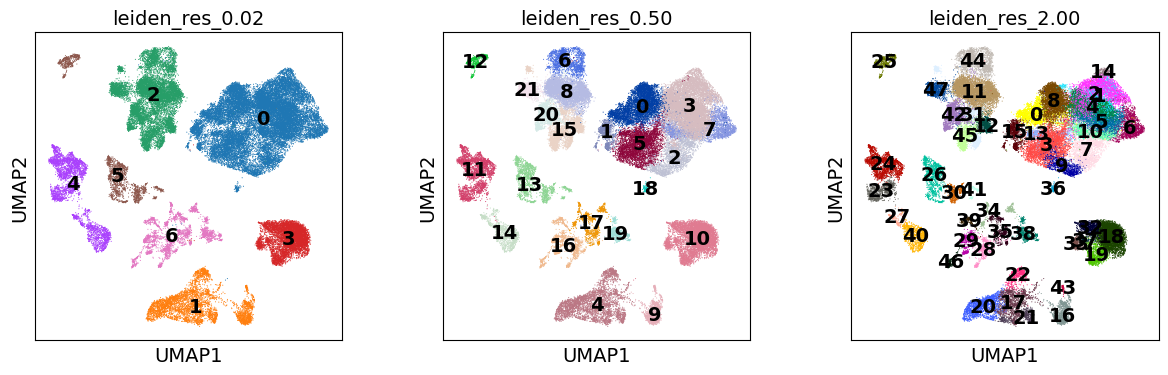

In [26]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

## Marker Gene Set

In [31]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1"], #, "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

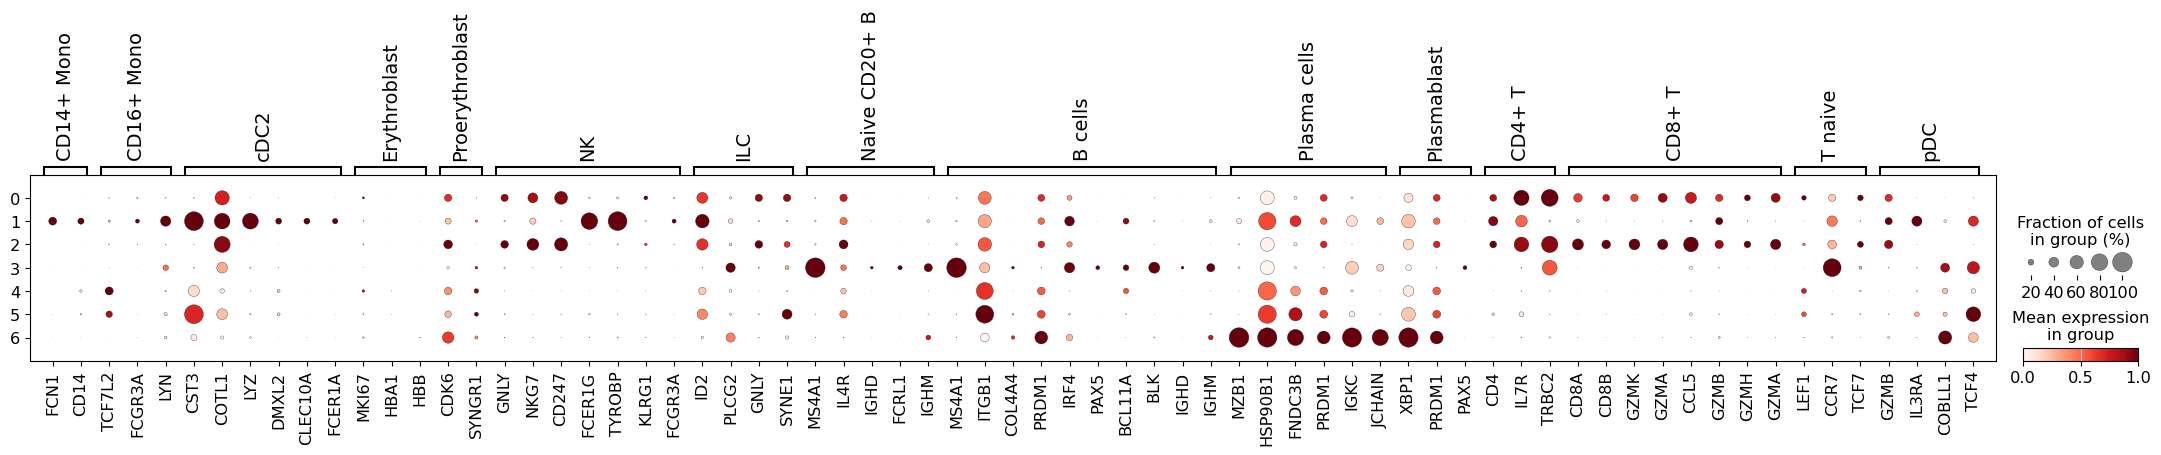

In [32]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

In [33]:
adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
    }
)

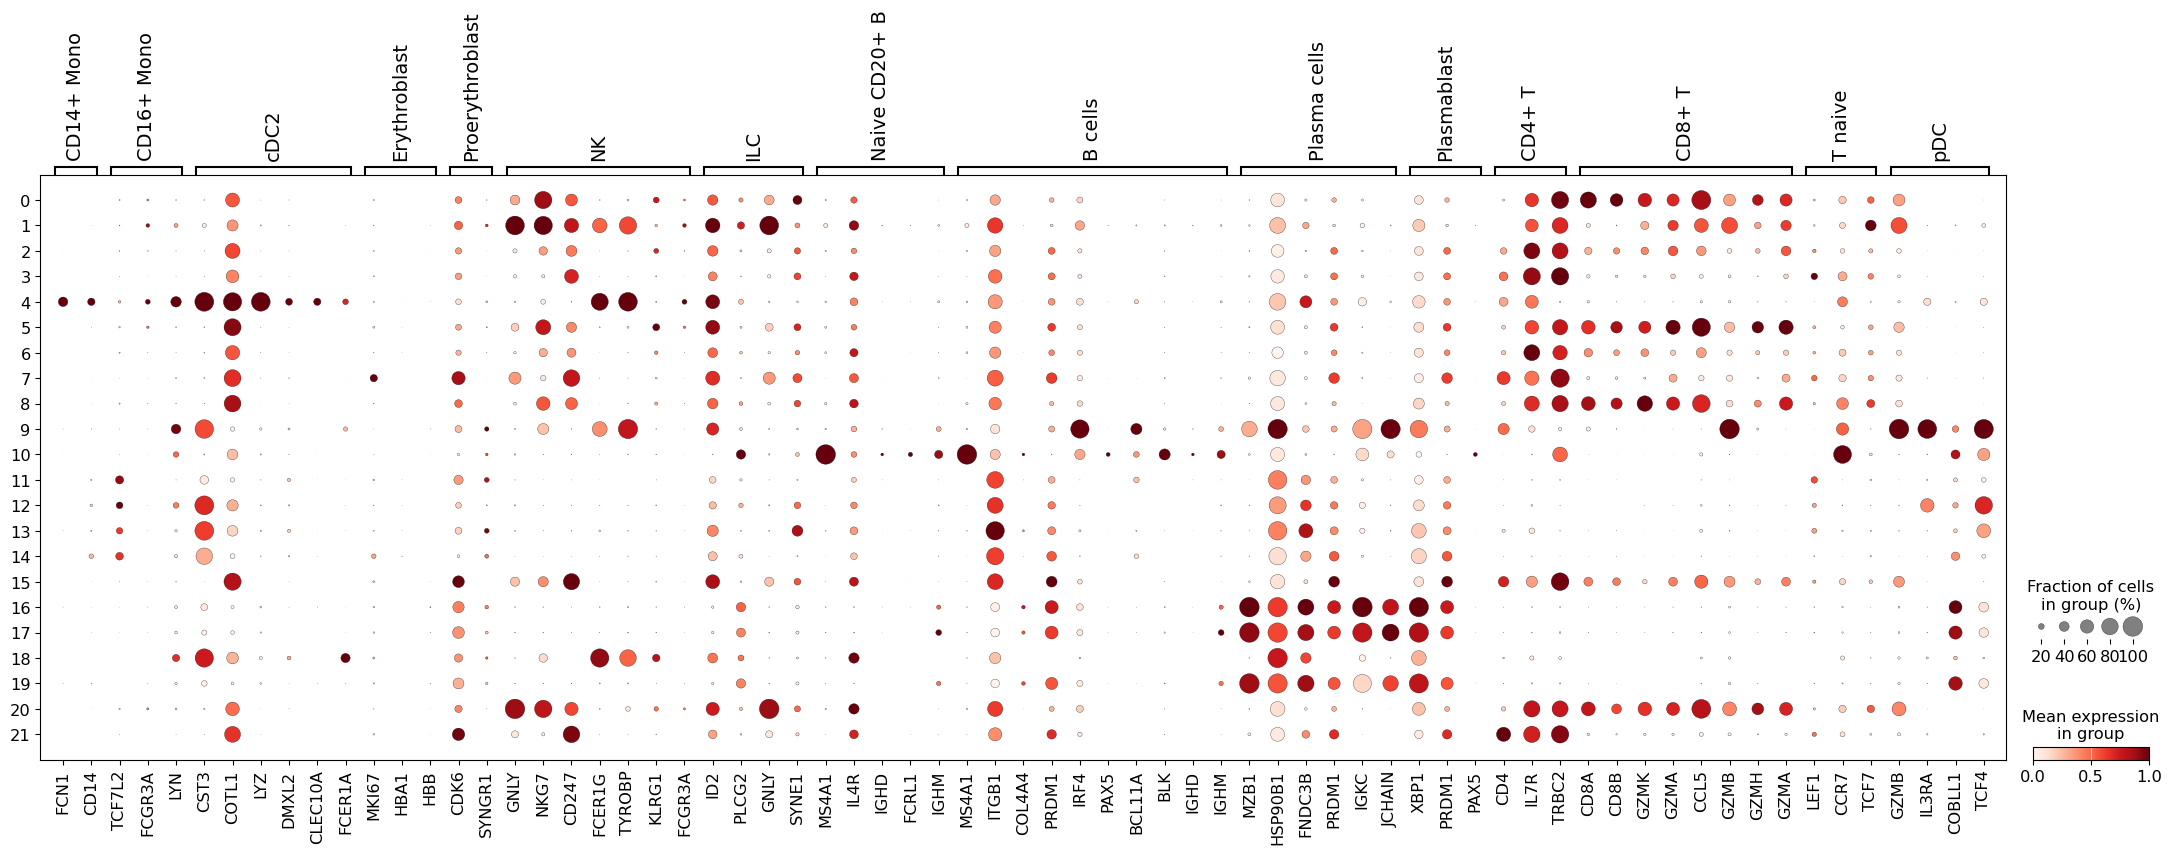

In [34]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

## Differentially-expressed Genes as Marker

In [35]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  This is usu

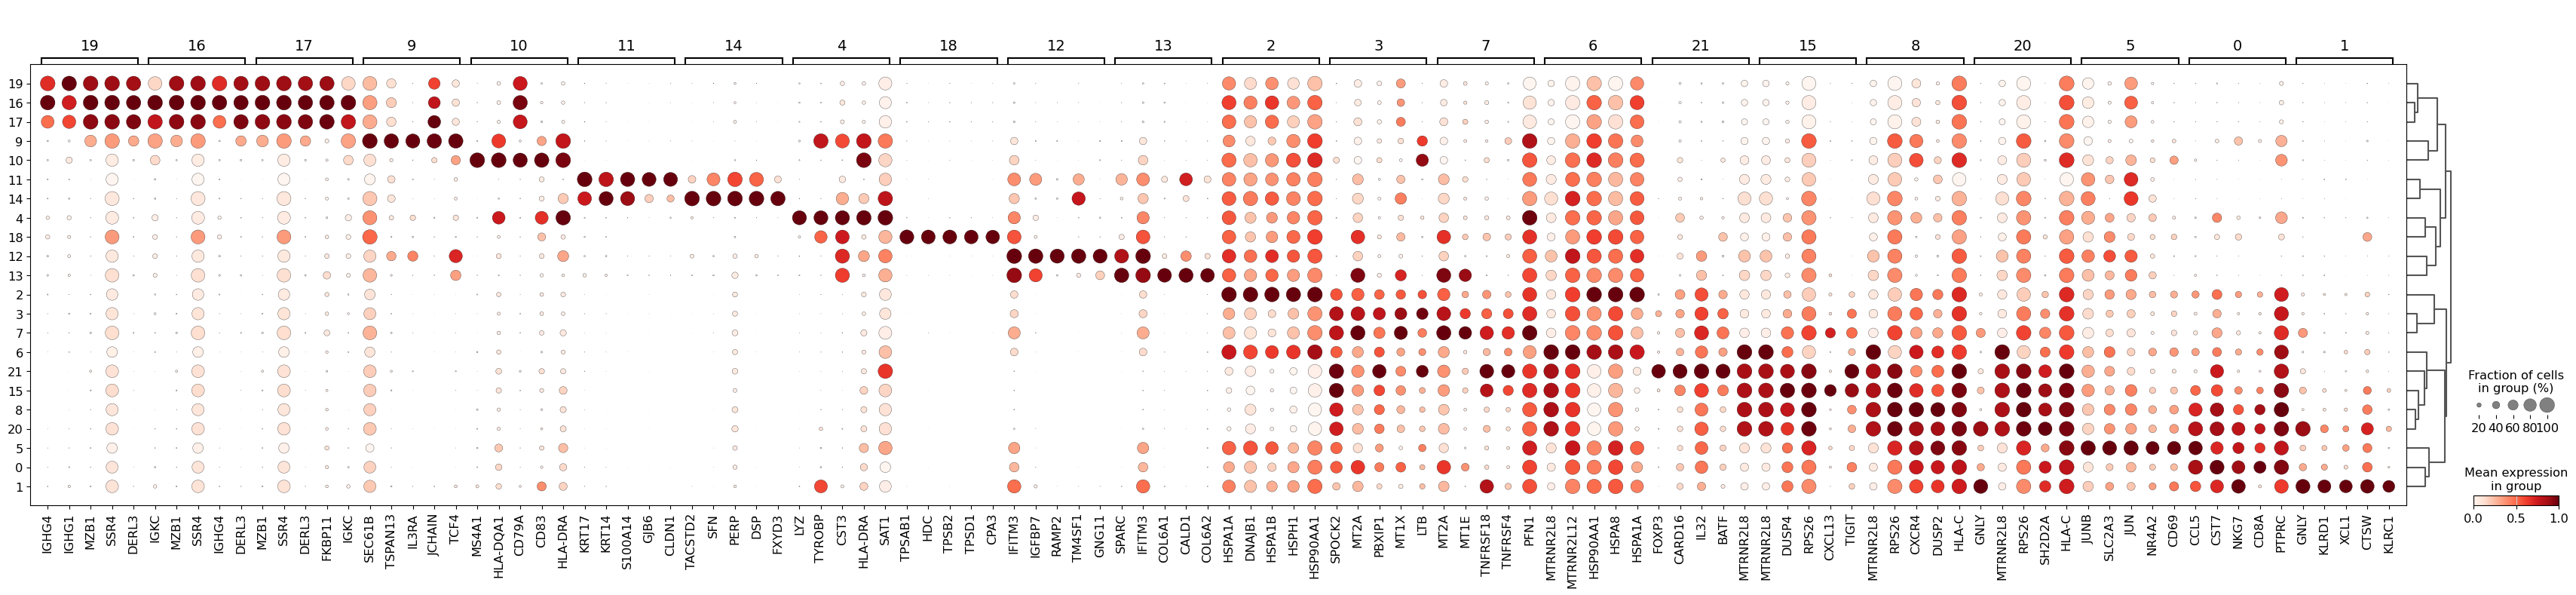

In [36]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

In [37]:
sc.get.rank_genes_groups_df(adata, group="7").head(5)

names     scores  logfoldchanges  pvals  pvals_adj
0      MT2A  52.752869        2.600182    0.0        0.0
1      MT1E  52.387360        3.003830    0.0        0.0
2  TNFRSF18  48.496880        2.154601    0.0        0.0
3   TNFRSF4  44.983608        2.197297    0.0        0.0
4      PFN1  44.662582        1.266463    0.0        0.0

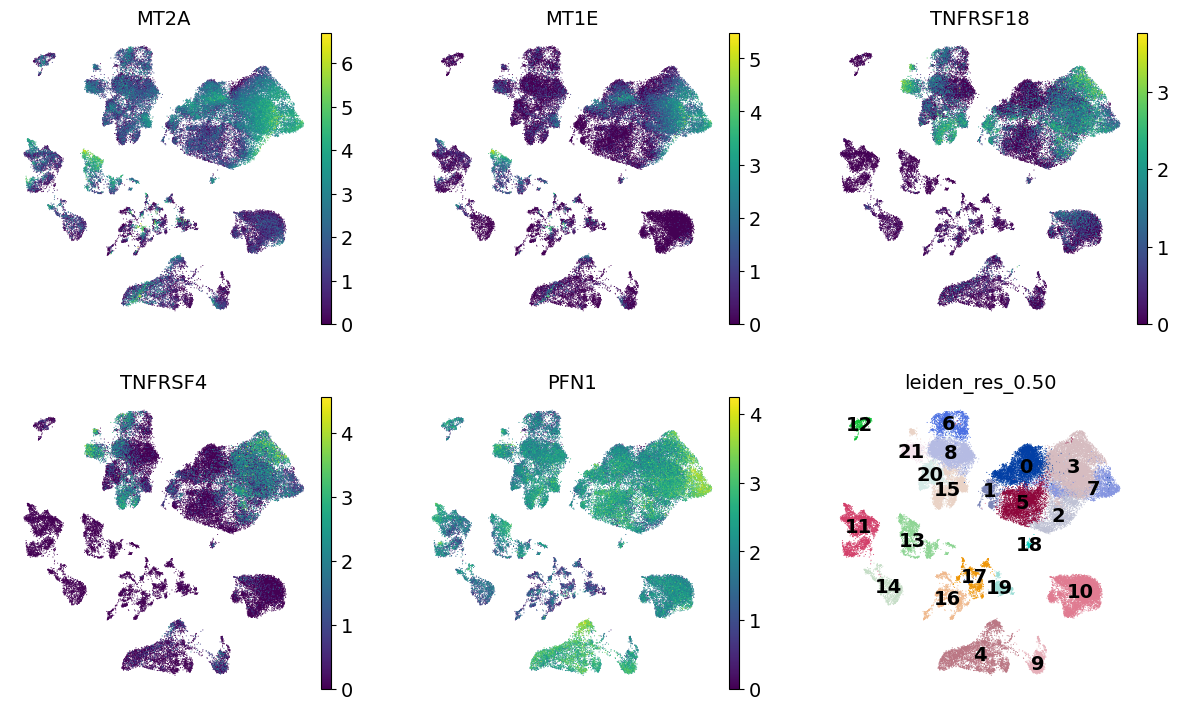

In [41]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

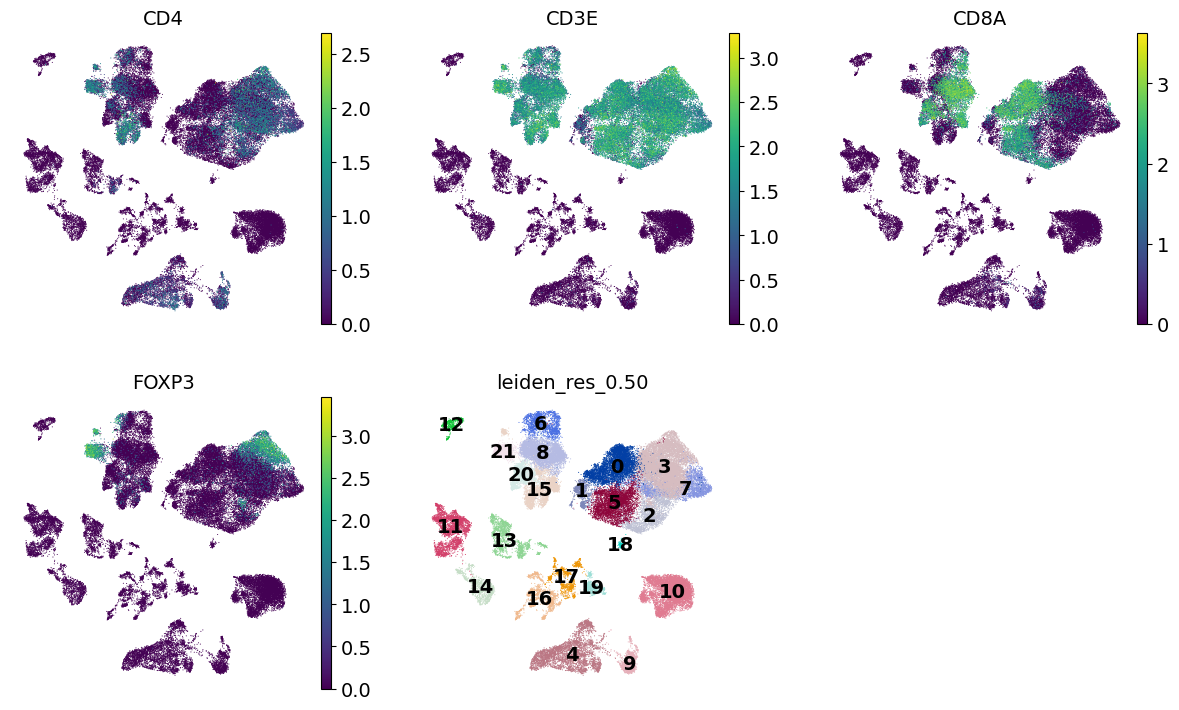

In [42]:
sc.pl.umap(
    adata,
    color=["CD4", "CD3E", "CD8A", "FOXP3", "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)